In [6]:
from pyspark.sql import SparkSession
import time

#Start stopwatch
startTime = time.time()

# (8 cores, 16gb per machine) x 5 = 40 cores

# New API
spark_session = SparkSession\
        .builder\
        .master("spark://192.168.1.153:7077") \
        .appName("group_09")\
        .config("spark.dynamicAllocation.enabled", True)\
        .config("spark.shuffle.service.enabled", True)\
        .config("spark.dynamicAllocation.executorIdleTimeout","30s")\
        .config("spark.executor.cores",4)\
        .getOrCreate()
      
        
# Old API (RDD)
spark_context = spark_session.sparkContext

In [2]:
import h5py
import sys
import io

rdd = spark_context.binaryFiles("hdfs://192.168.1.153:9000/millionsongs/data/*/*/*/*")

     # read a dataset and return it as a Python list #

def f(x):
    # return print(sys.path)
    
    # x[0] = filename
    # x[1] = binary content
    with h5py.File(io.BytesIO(x[1])) as f:
        # drill down with a path
        #return list(f.keys())
        g = f['analysis']['songs']['duration']
        # g is a 'dataset'
        return list(g)

rdd = rdd.map(f).cache()

In [3]:
def time_conversion(duration):
    duration_in_half_minutes = duration[0]/30
    discretitized_duration = round(duration_in_half_minutes)
    discretized_duration_in_minutes = discretitized_duration/2
    return discretized_duration_in_minutes

converted_rdd = rdd.map(time_conversion)
print(converted_rdd.take(10))
print(converted_rdd.count())

[4.0, 10.0, 2.0, 4.0, 2.5, 8.0, 5.0, 4.0, 5.0, 7.0]
10000


In [4]:
result = converted_rdd.map(lambda time: (time, 1)).reduceByKey(lambda a, b: a + b).sortBy(lambda x: x[0], True)
print(result.take(10))
endTime = time.time()
print("Time Elapsed {}".format((endTime-startTime)/60))

[(0.0, 19), (0.5, 102), (1.0, 145), (1.5, 229), (2.0, 499), (2.5, 986), (3.0, 1496), (3.5, 1633), (4.0, 1558), (4.5, 1119)]
Time Elapsed 2.1180098136266072


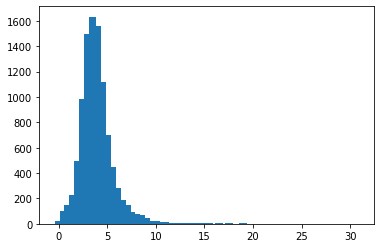

In [7]:
import matplotlib.pyplot as plt
plt.bar(*zip(*result.collect()))
plt.show()